In [2]:
!pip install psycopg2-binary matplotlib seaborn scipy

import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Koneksi Database
db_config = {
    "host": "postgres-warehouse",
    "port": "5432",
    "database": "f1_datawarehouse",
    "user": "warehouse_user",
    "password": "warehouse_password"
}

def get_data(query):
    try:
        conn = psycopg2.connect(**db_config)
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error Database: {e}")
        return None

# 1. Ambil SEMUA data dulu (Tanpa WHERE di SQL biar gak error nama kolom)
df = get_data("SELECT * FROM circuit_summary")

if df is not None:
    # 2. Kita filter pakai Pandas (Python lebih pinter baca huruf besar/kecil)
    df = df[df['Total_Laps_Recorded'] > 10]
    
    print(f"Data Ready: {df.shape[0]} Rows.")
    display(df.head())
else:
    print("Gagal mengambil data.")

Data Ready: 142 Rows.


/tmp/ipykernel_329/3897253392.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,Year,Circuit,EventName,Avg_LapTime,Best_LapTime,Avg_Full_Throttle,Avg_Brake_Load,Top_Speed,Total_Laps_Recorded
0,2018,Austin,United States Grand Prix,109.599989,92.237,36.522408,1.0000,329.0,348
1,2018,Baku,Azerbaijan Grand Prix,115.957900,101.498,44.818452,1.0000,348.0,440
2,2018,Barcelona,Spanish Grand Prix,90.786553,76.173,40.230047,1.0000,329.0,438
3,2018,Budapest,Hungarian Grand Prix,93.867234,76.666,31.965776,1.0000,331.0,308
4,2018,Hockenheim,German Grand Prix,89.723980,71.212,39.826347,0.9801,330.0,402


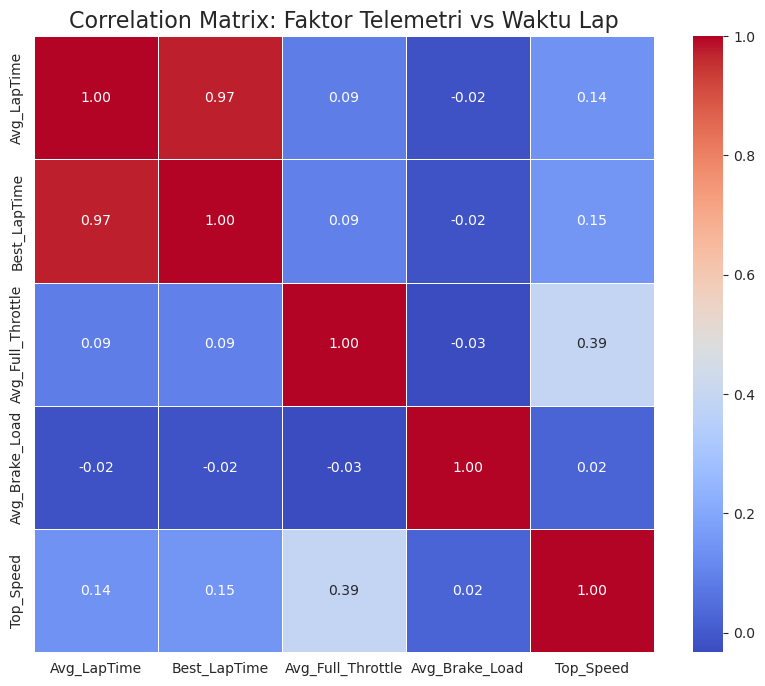

In [3]:
# Pilih kolom numerik untuk korelasi
cols_to_corr = ['Avg_LapTime', 'Best_LapTime', 'Avg_Full_Throttle', 'Avg_Brake_Load', 'Top_Speed']
corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Faktor Telemetri vs Waktu Lap", fontsize=16)
plt.show()

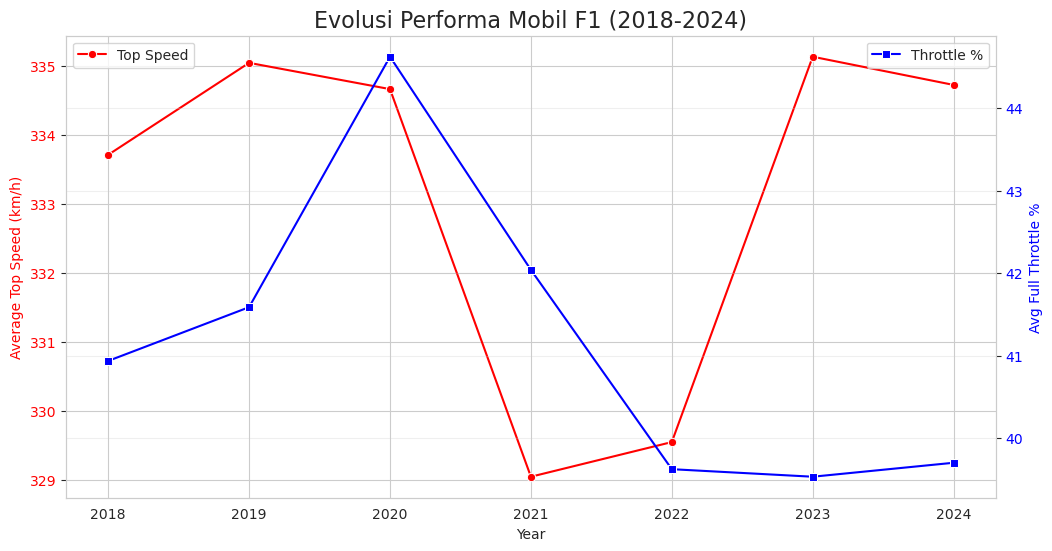

In [4]:
# Agregasi rata-rata per tahun (mengabaikan perbedaan sirkuit)
yearly_trend = df.groupby('Year')[['Top_Speed', 'Avg_Full_Throttle']].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Top Speed (Garis Merah)
sns.lineplot(data=yearly_trend, x='Year', y='Top_Speed', marker='o', color='red', ax=ax1, label='Top Speed')
ax1.set_ylabel('Average Top Speed (km/h)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Plot Full Throttle (Garis Biru)
ax2 = ax1.twinx()
sns.lineplot(data=yearly_trend, x='Year', y='Avg_Full_Throttle', marker='s', color='blue', ax=ax2, label='Throttle %')
ax2.set_ylabel('Avg Full Throttle %', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title("Evolusi Performa Mobil F1 (2018-2024)", fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

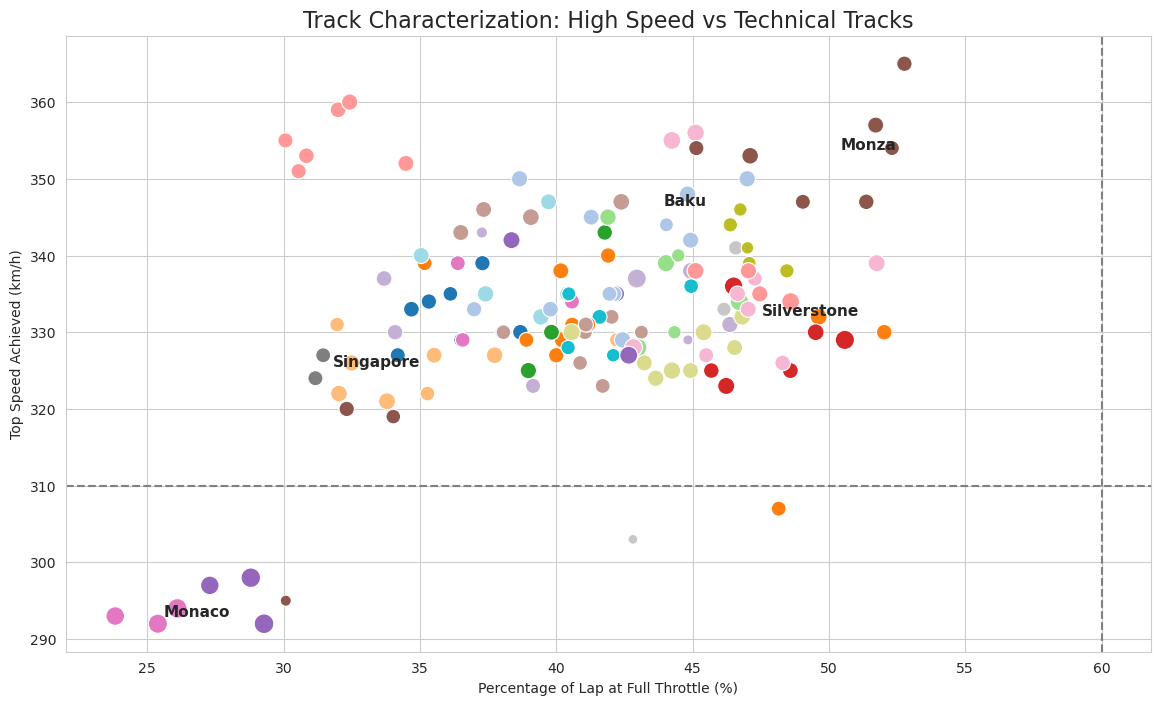

In [5]:
plt.figure(figsize=(14, 8))

# Scatter Plot
sns.scatterplot(
    data=df, 
    x='Avg_Full_Throttle', 
    y='Top_Speed', 
    hue='Circuit', 
    size='Total_Laps_Recorded',
    sizes=(50, 200),
    palette='tab20',
    legend=False # Hide legend karena sirkuitnya banyak
)

circuit_locs = df.groupby('Circuit')[['Avg_Full_Throttle', 'Top_Speed']].mean()

target_circuits = ['Monza', 'Monaco', 'Silverstone', 'Spa', 'Singapore', 'Baku']

for circuit in target_circuits:
    if circuit in circuit_locs.index:
        x = circuit_locs.loc[circuit, 'Avg_Full_Throttle']
        y = circuit_locs.loc[circuit, 'Top_Speed']
        plt.text(x+0.5, y, circuit, fontsize=11, fontweight='bold')

plt.title("Track Characterization: High Speed vs Technical Tracks", fontsize=16)
plt.xlabel("Percentage of Lap at Full Throttle (%)")
plt.ylabel("Top Speed Achieved (km/h)")
plt.axvline(x=60, color='gray', linestyle='--') # Garis batas imajiner
plt.axhline(y=310, color='gray', linestyle='--')
plt.show()

/tmp/ipykernel_329/481379535.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heavy_braking.values, y=heavy_braking.index, palette="magma")


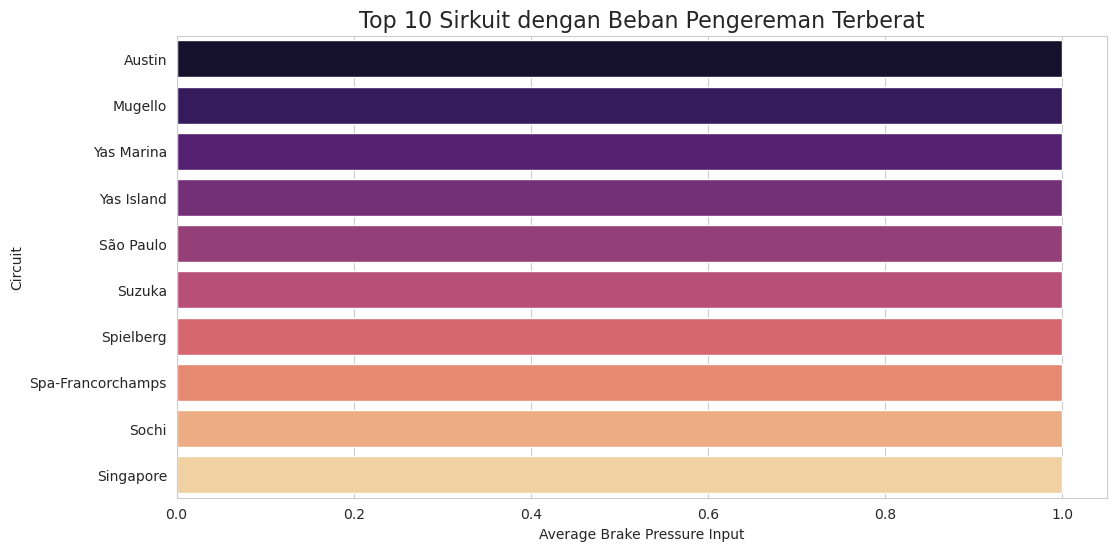

In [6]:
import pandas as pd
import psycopg2

# 1. Konfigurasi Database (Sama seperti sebelumnya)
db_config = {
    "host": "postgres-warehouse",
    "port": "5432",
    "database": "f1_datawarehouse",
    "user": "warehouse_user",
    "password": "warehouse_password"
}

# 2. INI BAGIAN SQL-NYA
# Kita tulis kodingan SQL-nya di dalam tanda kutip tiga (""")
query_cek_schema = """
SELECT column_name, data_type 
FROM information_schema.columns
WHERE table_name = 'circuit_summary';
"""

# 3. Eksekusi lewat Python
try:
    conn = psycopg2.connect(**db_config)
    
    # Python mengirim SQL tadi ke Database -> Hasilnya jadi Tabel Pandas
    df_schema = pd.read_sql(query_cek_schema, conn)
    
    conn.close()
    
    print("📋 Struktur Tabel (Schema) di PostgreSQL:")
    display(df_schema)
    
except Exception as e:
    print(f"Error: {e}")

In [7]:
import pandas as pd
import psycopg2

# 1. Konfigurasi Database (Sama seperti sebelumnya)
db_config = {
    "host": "postgres-warehouse",
    "port": "5432",
    "database": "f1_datawarehouse",
    "user": "warehouse_user",
    "password": "warehouse_password"
}

# 2. INI BAGIAN SQL-NYA
# Kita tulis kodingan SQL-nya di dalam tanda kutip tiga (""")
query_cek_schema = """
SELECT column_name, data_type 
FROM information_schema.columns
WHERE table_name = 'circuit_summary';
"""

# 3. Eksekusi lewat Python
try:
    conn = psycopg2.connect(**db_config)
    
    # Python mengirim SQL tadi ke Database -> Hasilnya jadi Tabel Pandas
    df_schema = pd.read_sql(query_cek_schema, conn)
    
    conn.close()
    
    print("📋 Struktur Tabel (Schema) di PostgreSQL:")
    display(df_schema)
    
except Exception as e:
    print(f"Error: {e}")

📋 Struktur Tabel (Schema) di PostgreSQL:


/tmp/ipykernel_329/3508640896.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_schema = pd.read_sql(query_cek_schema, conn)


,column_name,data_type
0,Total_Laps_Recorded,bigint
1,Top_Speed,double precision
2,Year,integer
3,Avg_LapTime,double precision
4,Best_LapTime,double precision
5,Avg_Full_Throttle,double precision
6,Avg_Brake_Load,double precision
7,Circuit,text
8,EventName,text


In [10]:
import pandas as pd
import psycopg2

# 1. Konfigurasi Database
db_config = {
    "host": "postgres-warehouse",
    "port": "5432",
    "database": "f1_datawarehouse",
    "user": "warehouse_user",
    "password": "warehouse_password"
}

# 2. BUKA KONEKSI BARU
conn = psycopg2.connect(**db_config)

# 3. Ambil Data
try:
    df = pd.read_sql("SELECT * FROM circuit_summary LIMIT 10", conn)
    
    print("5 Baris Data")
    display(df.head())
    
    print("\nInfo Tipe Data")
    print(df.info())
    
finally:
    # 4. Tutup Koneksi (Biar sopan sama server)
    conn.close()

5 Baris Data


/tmp/ipykernel_329/3167878785.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM circuit_summary LIMIT 10", conn)


,Year,Circuit,EventName,Avg_LapTime,Best_LapTime,Avg_Full_Throttle,Avg_Brake_Load,Top_Speed,Total_Laps_Recorded
0,2018,Austin,United States Grand Prix,109.599989,92.237,36.522408,1.0000,329.0,348
1,2018,Baku,Azerbaijan Grand Prix,115.957900,101.498,44.818452,1.0000,348.0,440
2,2018,Barcelona,Spanish Grand Prix,90.786553,76.173,40.230047,1.0000,329.0,438
3,2018,Budapest,Hungarian Grand Prix,93.867234,76.666,31.965776,1.0000,331.0,308
4,2018,Hockenheim,German Grand Prix,89.723980,71.212,39.826347,0.9801,330.0,402



Info Tipe Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 10 non-null     int64  
 1   Circuit              10 non-null     object 
 2   EventName            10 non-null     object 
 3   Avg_LapTime          10 non-null     float64
 4   Best_LapTime         10 non-null     float64
 5   Avg_Full_Throttle    10 non-null     float64
 6   Avg_Brake_Load       10 non-null     float64
 7   Top_Speed            10 non-null     float64
 8   Total_Laps_Recorded  10 non-null     int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 852.0+ bytes
None
